# Extract annotations and data from UniProtKB

The purpose of this notebook is to extract and format UniProt data for subsequent model annotation.

Additionally, the purpose of this notebook is to extract data and other annotations related to model proteins.

## Notebook Requirements:
*  Model genes **must** have the at least one of following annotations stored in the `object.annotation`. Values are expected to be seperated by semicolons. Accepted keys currently include:
    * `"uniprot"`
* Note: Requires internet connection to download information from the [Universal Protein Resource (UniProt)](https://www.uniprot.org/).
    *  [UniProt Knowledgebase (UniProtKB)](https://www.uniprot.org/help/uniprotkb)

### Citation
UniProt Consortium. UniProt: the Universal Protein Knowledgebase in 2023. Nucleic Acids Res. 2023 Jan 6;51(D1):D523-D531. doi: 10.1093/nar/gkac1052. PMID: 36408920; PMCID: PMC9825514.

## Setup
### Import packages

In [1]:
import re
from warnings import warn

import matplotlib.pyplot as plt
import pandas as pd
from rbc_gem_utils import (
    GEM_NAME,
    build_string,
    check_database_release_online,
    compare_tables,
    get_annotation_df,
    get_dirpath,
    read_cobra_model,
    show_versions,
    split_string,
    visualize_comparison,
)
from rbc_gem_utils.database.uniprot import (
    UNIPROT_DB_TAG,
    UNIPROT_RELEASE_EXPECTED,
    get_annotation_to_from_db_UniProt,
    get_isoform_value_from_entry_UniProt,
    get_label_miriam_mapping_UniProt,
    get_query_fields_UniProt,
    parse_chains_UniProt,
    parse_isoforms_UniProt,
    query_UniProt,
)

# Display versions of last time notebook ran and worked
show_versions()


Package Information
-------------------
rbc-gem-utils 0.0.1

Dependency Information
----------------------
beautifulsoup4                       4.12.3
bio                                   1.6.2
cobra                                0.29.0
depinfo                               2.2.0
kaleido                               0.2.1
matplotlib                            3.8.2
memote                               0.17.0
networkx                              3.2.1
notebook                              7.0.7
openpyxl                              3.1.2
pandas                                2.2.0
pre-commit                            3.6.0
pyvis                                 0.3.2
rbc-gem-utils[database,network,vis] missing
requests                             2.31.0
scipy                                1.12.0
seaborn                              0.13.2

Build Tools Information
-----------------------
pip        23.3.1
setuptools 68.2.2
wheel      0.41.2

Platform Information
-------------------

## Set notebook options

In [2]:
db_tag = UNIPROT_DB_TAG
expected_release = UNIPROT_RELEASE_EXPECTED

compare_figsize = (5, 20)
compare = True
display_nunique = True
overwrite = True

## Check UniProt release
If the release does not match the expected release, it is because database has been updated since the last time this code was utilized. 

* According to [UniProt](https://www.uniprot.org/help/downloads), updates to the database are made every eight weeks.
* If the current release does not match the expected release, it is because database has been updated since the last time this code was utilized.
    * If the notebook works without needing any significant modifications, the only update needed is to the release in the [uniprot.py](../../src/rbc_gem_utils/database/uniprot.py) source code file to resolve the issue.


In [3]:
use_interim = not check_database_release_online(db_tag, verbose=True, **{})
# Use different directory paths for unexpected behavior
if use_interim:
    warn(
        "Online release of database has been updated since the last time notebook was used."
    )


database_dirpath = get_dirpath(
    "database", db_tag, use_temp="interim" if use_interim else None
)
annotation_dirpath = get_dirpath(
    "annotation", use_temp="interim" if use_interim else None
)

# Ensure directories exist
database_dirpath.mkdir(exist_ok=True, parents=True)
annotation_dirpath.mkdir(exist_ok=True, parents=True)

Current and expected releases match. Current release: 2025_02


## Load RBC-GEM model

In [4]:
model_dirpath = get_dirpath("model")
model = read_cobra_model(filename=model_dirpath / f"{GEM_NAME}.xml")
model

Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-21


Name,RBC_GEM
Memory address,14afb0ed0
Number of metabolites,2157
Number of reactions,3275
Number of genes,820
Number of groups,78
Objective expression,1.0*NaKt - 1.0*NaKt_reverse_db47e
Compartments,"cytosol, extracellular space"


## Download data from UniProt

### Get IDs for query
#### Using an existing annotation

In [5]:
annotation_type = "genes"
annotation_cols = ["uniprot"]
mapping_key = "uniprot"

df_model_mappings = (
    get_annotation_df(model.genes, annotation_cols)
    .rename({"id": annotation_type}, axis=1)
    .dropna(subset=[mapping_key])
)
for col in df_model_mappings.columns:
    df_model_mappings[col] = df_model_mappings[col].apply(lambda x: split_string(x))
    df_model_mappings = df_model_mappings.explode(col).drop_duplicates().dropna()
df_model_mappings = df_model_mappings.sort_values(annotation_type)

print(df_model_mappings.nunique(dropna=True))
df_model_mappings = df_model_mappings.reset_index(drop=True)
df_model_mappings

genes      820
uniprot    820
dtype: int64


,genes,uniprot
0,A4GALT,Q9NPC4
1,AARS1,P49588
2,AASDHPPT,Q9NRN7
3,ABCA1,O95477
4,ABCA7,Q8IZY2
...,...,...
815,YES1,P07947
816,ZDHHC2,Q9UIJ5
817,ZDHHC20,Q5W0Z9
818,ZDHHC3,Q9NYG2


In [6]:
annotation_to_from_db = get_annotation_to_from_db_UniProt(miriam_only=True)

from_db = annotation_to_from_db[mapping_key]
query_ids = df_model_mappings[mapping_key].dropna().unique()
assert len(set(query_ids)) == len(query_ids), "Duplicate IDs in list to query"
model_search_mapping = df_model_mappings.set_index(annotation_type)[
    mapping_key
].to_dict()
print(f"Number of model genes associated with query: {len(model_search_mapping)}")
print(f"Number of unique IDs to query: {len(query_ids)}")
df_model_mappings[[annotation_type, mapping_key]].drop_duplicates()

Number of model genes associated with query: 820
Number of unique IDs to query: 820


,genes,uniprot
0,A4GALT,Q9NPC4
1,AARS1,P49588
2,AASDHPPT,Q9NRN7
3,ABCA1,O95477
4,ABCA7,Q8IZY2
...,...,...
815,YES1,P07947
816,ZDHHC2,Q9UIJ5
817,ZDHHC20,Q5W0Z9
818,ZDHHC3,Q9NYG2


## Run queries
### Set universal query parameters

In [7]:
all_query_results = {}

In [8]:
miriam_query_fields = get_query_fields_UniProt(miriam_only=True)
query_fields = miriam_query_fields + [
    # Add additional non-miriam fields if desired
    # Complex composition
    "cc_subunit",
    # Specific isoforms to include/avoid
    "cc_tissue_specificity",
    "cc_subcellular_location",
    # Chromosome
    "xref_proteomes",
]

In [9]:
# Extract all relevant information for now and save
query_parameters = {
    "query": " && ".join(
        [
            "(reviewed:true)",
            "(organism_id:9606)",  # Homo sapiens (Human)
        ]
    ),
    "format": "tsv",
    "size": 500,
    "compressed": True,
    "fields": ",".join(query_fields),
}

### Initial query

In [10]:
query_key = "initial"
df_results, uniparc, failed_ids, obselete_counts = query_UniProt(
    list(query_ids),
    query_parameters=query_parameters,
    to_db="UniProtKB",
    from_db=from_db,
    return_failed=True,
)
if failed_ids:
    print(failed_ids)
all_query_results[query_key] = df_results
df_results

Fetched: 500 / 820
Fetched: 820 / 820


,From,Entry,Gene Names (primary),Organism (ID),Alternative products (isoforms),EC number,Rhea ID,UniParc,Gene Ontology IDs,Chain,...,Pfam,PIRSF,PRINTS,PROSITE,SMART,SUPFAM,Subunit structure,Tissue specificity,Subcellular location [CC],Proteomes
0,A0AVT1,A0AVT1,UBA6,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,6.2.1.45,,UPI000004A4F7,GO:0004839; GO:0005524; GO:0005634; GO:0005737...,"CHAIN 1..1052; /note=""Ubiquitin-like modifier-...",...,PF16191;PF16190;PF09358;PF00899;PF10585;,,PR01849;,,SM00985;,SSF69572;,SUBUNIT: Forms a thioester with UBD in cells s...,TISSUE SPECIFICITY: Widely expressed. Isoform ...,,UP000005640: Chromosome 4
1,A4D126,A4D126,CRPPA,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,2.7.7.40,RHEA:12456 RHEA:53872 RHEA:53612,UPI00015CFC06,GO:0005829; GO:0007411; GO:0008299; GO:0035269...,"CHAIN 1..451; /note=""D-ribitol-5-phosphate cyt...",...,PF01128;PF18706;,,,PS01295;,,SSF53448;,SUBUNIT: Homodimer. {ECO:0000269|PubMed:266871...,"TISSUE SPECIFICITY: Ubiquitously expressed, wi...","SUBCELLULAR LOCATION: Cytoplasm, cytosol {ECO:...",UP000005640: Chromosome 7
2,A6NDG6,A6NDG6,PGP,9606,ALTERNATIVE PRODUCTS:,3.1.3.21; 3.1.3.48,RHEA:10684 RHEA:46084 RHEA:66372,UPI00000473F8,GO:0000121; GO:0000287; GO:0004725; GO:0004726...,"CHAIN 1..321; /note=""Glycerol-3-phosphate phos...",...,PF13344;PF13242;,PIRSF000915;,,,,SSF56784;,SUBUNIT: Homodimer. {ECO:0000250|UniProtKB:Q8C...,TISSUE SPECIFICITY: Detected in all tissues in...,,UP000005640: Chromosome 16
3,A6NFX1,A6NFX1,MFSD2B,9606,ALTERNATIVE PRODUCTS:,,RHEA:38667 RHEA:38671 RHEA:70207,UPI000047F9C2,GO:0003376; GO:0005886; GO:0006869; GO:0008643...,"CHAIN 1..504; /note=""Sphingosine-1-phosphate t...",...,PF13347;,,,,,SSF103473;,,,SUBCELLULAR LOCATION: Cell membrane {ECO:00002...,UP000005640: Chromosome 2
4,O00154,O00154,ACOT7,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,3.1.2.2,RHEA:16645 RHEA:30143 RHEA:30135 RHEA:40139 RH...,UPI000012674F,GO:0000062; GO:0005654; GO:0005737; GO:0005739...,"CHAIN 1..380; /note=""Cytosolic acyl coenzyme A...",...,PF03061;,,,PS51770;,,SSF54637;,SUBUNIT: Homohexamer. {ECO:0000250|UniProtKB:Q...,TISSUE SPECIFICITY: Isoform 4 is expressed exc...,"SUBCELLULAR LOCATION: [Isoform 4]: Cytoplasm, ...",UP000005640: Chromosome 1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
815,Q9Y666,Q9Y666,SLC12A7,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,,RHEA:72427,UPI0000141815,GO:0005886; GO:0006811; GO:0006884; GO:0007268...,"CHAIN 1..1083; /note=""Solute carrier family 12...",...,PF00324;PF03522;,,PR01081;,,,,SUBUNIT: Homodimer; adopts a domain-swap confo...,"TISSUE SPECIFICITY: Detected in muscle, brain,...",SUBCELLULAR LOCATION: Cell membrane {ECO:00002...,UP000005640: Chromosome 5
816,Q9Y694,Q9Y694,SLC22A7,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,,RHEA:72043 RHEA:76207 RHEA:76211 RHEA:76215 RH...,UPI000006F307,GO:0005829; GO:0005886; GO:0006805; GO:0006811...,"CHAIN 1..548; /note=""Solute carrier family 22 ...",...,PF07690;,,,PS50850;,,SSF103473;,,TISSUE SPECIFICITY: Mainly expressed in liver ...,SUBCELLULAR LOCATION: [Isoform 2]: Basolateral...,UP000005640: Chromosome 6
817,Q9Y696,Q9Y696,CLIC4,9606,ALTERNATIVE PRODUCTS:,1.8.-.-,RHEA:29823 RHEA:75347 RHEA:34923 RHEA:66324 RH...,UPI0000127AC9,GO:0001525; GO:0001886; GO:0005254; GO:0005737...,"CHAIN 2..253; /note=""Chloride intracellular ch...",...,PF22441;,,PR01263;,PS50405;,,SSF47616;SSF52833;,SUBUNIT: Component of a multimeric complex con...,TISSUE SPECIFICITY: Detected in epithelial cel...,"SUBCELLULAR LOCATION: Cytoplasm, cytoskeleton,...",UP000005640: Chromosome 1
818,Q9Y6M4,Q9Y6M4,CSNK1G3,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,2.7.11.1,RHEA:17989 RHEA:46608,UPI000035B1BD,GO:0004672; GO:0004674; GO:0004676; GO:0004677...,"CHAIN 1..447; /note=""Casein kinase I isoform g...",...,PF12605;PF00069;,,,PS00107;PS50011;PS00108;,SM00220;,SSF56112;,SUBUNIT: Monomer. {ECO:0000250}.,,SUBCELLULAR LOCATION: Cyto

### Address failed IDs

In [11]:
# retry_ids = {}
# query_key = "retry_1"
# df_results, failed_ids = query_UniProt(
#     list(sorted(retry_ids.values())),
#     from_db="UniProtKB",
#     query_parameters=query_parameters
# )
# if failed_ids:
#     print(failed_ids)
# all_query_results[query_key] = df_results
# model_search_mapping.update({
#     k: retry_ids[v] for k, v in model_search_mapping.items()
#     if v in retry_ids and v not in failed_ids
# })
# df_results

## Concat, cleanup, and save query results

In [12]:
print(f"Number of unique queries: {len(all_query_results)}")
df_query_results = pd.concat(tuple(all_query_results.values()))
df_query_results = df_query_results.set_index("From").drop_duplicates()
df_query_results = df_query_results.replace("", pd.NA)
df_query_results

Number of unique queries: 1


,Entry,Gene Names (primary),Organism (ID),Alternative products (isoforms),EC number,Rhea ID,UniParc,Gene Ontology IDs,Chain,PubMed ID,...,Pfam,PIRSF,PRINTS,PROSITE,SMART,SUPFAM,Subunit structure,Tissue specificity,Subcellular location [CC],Proteomes
From,,,,,,,,,,,,,,,,,,,,,
A0AVT1,A0AVT1,UBA6,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,6.2.1.45,<NA>,UPI000004A4F7,GO:0004839; GO:0005524; GO:0005634; GO:0005737...,"CHAIN 1..1052; /note=""Ubiquitin-like modifier-...",15202508; 17597759; 14702039; 17974005; 158156...,...,PF16191;PF16190;PF09358;PF00899;PF10585;,<NA>,PR01849;,<NA>,SM00985;,SSF69572;,SUBUNIT: Forms a thioester with UBD in cells s...,TISSUE SPECIFICITY: Widely expressed. Isoform ...,<NA>,UP000005640: Chromosome 4
A4D126,A4D126,CRPPA,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,2.7.7.40,RHEA:12456 RHEA:53872 RHEA:53612,UPI00015CFC06,GO:0005829; GO:0007411; GO:0008299; GO:0035269...,"CHAIN 1..451; /note=""D-ribitol-5-phosphate cyt...",12853948; 12690205; 22522420; 26923585; 271307...,...,PF01128;PF18706;,<NA>,<NA>,PS01295;,<NA>,SSF53448;,SUBUNIT: Homodimer. {ECO:0000269|PubMed:266871...,"TISSUE SPECIFICITY: Ubiquitously expressed, wi...","SUBCELLULAR LOCATION: Cytoplasm, cytosol {ECO:...",UP000005640: Chromosome 7
A6NDG6,A6NDG6,PGP,9606,ALTERNATIVE PRODUCTS:,3.1.3.21; 3.1.3.48,RHEA:10684 RHEA:46084 RHEA:66372,UPI00000473F8,GO:0000121; GO:0000287; GO:0004725; GO:0004726...,"CHAIN 1..321; /note=""Glycerol-3-phosphate phos...",15616553; 215071; 21269460; 26755581,...,PF13344;PF13242;,PIRSF000915;,<NA>,<NA>,<NA>,SSF56784;,SUBUNIT: Homodimer. {ECO:0000250|UniProtKB:Q8C...,TISSUE SPECIFICITY: Detected in all tissues in...,<NA>,UP000005640: Chromosome 16
A6NFX1,A6NFX1,MFSD2B,9606,ALTERNATIVE PRODUCTS:,<NA>,RHEA:38667 RHEA:38671 RHEA:70207,UPI000047F9C2,GO:0003376; GO:0005886; GO:0006869; GO:0008643...,"CHAIN 1..504; /note=""Sphingosine-1-phosphate t...",15815621; 18694395; 29045386; 29563527,...,PF13347;,<NA>,<NA>,<NA>,<NA>,SSF103473;,<NA>,<NA>,SUBCELLULAR LOCATION: Cell membrane {ECO:00002...,UP000005640: Chromosome 2
O00154,O00154,ACOT7,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,3.1.2.2,RHEA:16645 RHEA:30143 RHEA:30135 RHEA:40139 RH...,UPI000012674F,GO:0000062; GO:0005654; GO:0005737; GO:0005739...,"CHAIN 1..380; /note=""Cytosolic acyl coenzyme A...",10578051; 12435388; 14702039; 16710414; 154893...,...,PF03061;,<NA>,<NA>,PS51770;,<NA>,SSF54637;,SUBUNIT: Homohexamer. {ECO:0000250|UniProtKB:Q...,TISSUE SPECIFICITY: Isoform 4 is expressed exc...,"SUBCELLULAR LOCATION: [Isoform 4]: Cytoplasm, ...",UP000005640: Chromosome 1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9Y666,Q9Y666,SLC12A7,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,<NA>,RHEA:72427,UPI0000141815,GO:0005886; GO:0006811; GO:0006884; GO:0007268...,"CHAIN 1..1083; /note=""Solute carrier family 12...",10347194; 15372022; 15489334; 11214971; 179740...,...,PF00324;PF03522;,<NA>,PR01081;,<NA>,<NA>,<NA>,SUBUNIT: Homodimer; adopts a domain-swap confo...,"TISSUE SPECIFICITY: Detected in muscle, brain,...",SUBCELLULAR LOCATION: Cell membrane {ECO:00002...,UP000005640: Chromosome 5
Q9Y694,Q9Y694,SLC22A7,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,<NA>,RHEA:72043 RHEA:76207 RHEA:76211 RHEA:76215 RH...,UPI000006F307,GO:0005829; GO:0005886; GO:0006805; GO:0006811...,"CHAIN 1..548; /note=""Solute carrier family 22 ...",14702039; 14574404; 15489334; 11327718; 120235...,...,PF07690;,<NA>,<NA>,PS50850;,<NA>,SSF103473;,<NA>,TISSUE SPECIFICITY: Mainly expressed in liver ...,SUBCELLULAR LOCATION: [Isoform 2]: Basolateral...,UP000005640: Chromosome 6
Q9Y696,Q9Y696,CLIC4,9606,ALTERNATIVE PRODUCTS:,1.8.-.-,RHEA:29823 RHEA:75347 RHEA:34923 RHEA:66324 RH...,UPI0000127AC9,GO:0001525; GO:0001886; GO:0005254; GO:0005737...,"CHAIN 2..253; /note=""Chloride intracellular ch...",10070163; 10191309; 11230166; 15489334; 107931...,...,PF22441;,<NA>,PR01263;,PS50405;,<NA>,SSF47616;SSF52833;,SUBUNIT: Compone

### Save extracted data to database

,Entry,Gene Names (primary),Organism (ID),Alternative products (isoforms),EC number,Rhea ID,UniParc,Gene Ontology IDs,Chain,PubMed ID,...,Pfam,PIRSF,PRINTS,PROSITE,SMART,SUPFAM,Subunit structure,Tissue specificity,Subcellular location [CC],Proteomes
0,A0AVT1,UBA6,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,6.2.1.45,<NA>,UPI000004A4F7,GO:0004839; GO:0005524; GO:0005634; GO:0005737...,"CHAIN 1..1052; /note=""Ubiquitin-like modifier-...",15202508; 17597759; 14702039; 17974005; 158156...,...,PF16191;PF16190;PF09358;PF00899;PF10585;,<NA>,PR01849;,<NA>,SM00985;,SSF69572;,SUBUNIT: Forms a thioester with UBD in cells s...,TISSUE SPECIFICITY: Widely expressed. Isoform ...,<NA>,UP000005640: Chromosome 4
1,A4D126,CRPPA,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,2.7.7.40,RHEA:12456 RHEA:53872 RHEA:53612,UPI00015CFC06,GO:0005829; GO:0007411; GO:0008299; GO:0035269...,"CHAIN 1..451; /note=""D-ribitol-5-phosphate cyt...",12853948; 12690205; 22522420; 26923585; 271307...,...,PF01128;PF18706;,<NA>,<NA>,PS01295;,<NA>,SSF53448;,SUBUNIT: Homodimer. {ECO:0000269|PubMed:266871...,"TISSUE SPECIFICITY: Ubiquitously expressed, wi...","SUBCELLULAR LOCATION: Cytoplasm, cytosol {ECO:...",UP000005640: Chromosome 7
2,A6NDG6,PGP,9606,ALTERNATIVE PRODUCTS:,3.1.3.21; 3.1.3.48,RHEA:10684 RHEA:46084 RHEA:66372,UPI00000473F8,GO:0000121; GO:0000287; GO:0004725; GO:0004726...,"CHAIN 1..321; /note=""Glycerol-3-phosphate phos...",15616553; 215071; 21269460; 26755581,...,PF13344;PF13242;,PIRSF000915;,<NA>,<NA>,<NA>,SSF56784;,SUBUNIT: Homodimer. {ECO:0000250|UniProtKB:Q8C...,TISSUE SPECIFICITY: Detected in all tissues in...,<NA>,UP000005640: Chromosome 16
3,A6NFX1,MFSD2B,9606,ALTERNATIVE PRODUCTS:,<NA>,RHEA:38667 RHEA:38671 RHEA:70207,UPI000047F9C2,GO:0003376; GO:0005886; GO:0006869; GO:0008643...,"CHAIN 1..504; /note=""Sphingosine-1-phosphate t...",15815621; 18694395; 29045386; 29563527,...,PF13347;,<NA>,<NA>,<NA>,<NA>,SSF103473;,<NA>,<NA>,SUBCELLULAR LOCATION: Cell membrane {ECO:00002...,UP000005640: Chromosome 2
4,O00154,ACOT7,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,3.1.2.2,RHEA:16645 RHEA:30143 RHEA:30135 RHEA:40139 RH...,UPI000012674F,GO:0000062; GO:0005654; GO:0005737; GO:0005739...,"CHAIN 1..380; /note=""Cytosolic acyl coenzyme A...",10578051; 12435388; 14702039; 16710414; 154893...,...,PF03061;,<NA>,<NA>,PS51770;,<NA>,SSF54637;,SUBUNIT: Homohexamer. {ECO:0000250|UniProtKB:Q...,TISSUE SPECIFICITY: Isoform 4 is expressed exc...,"SUBCELLULAR LOCATION: [Isoform 4]: Cytoplasm, ...",UP000005640: Chromosome 1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
815,Q9Y666,SLC12A7,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,<NA>,RHEA:72427,UPI0000141815,GO:0005886; GO:0006811; GO:0006884; GO:0007268...,"CHAIN 1..1083; /note=""Solute carrier family 12...",10347194; 15372022; 15489334; 11214971; 179740...,...,PF00324;PF03522;,<NA>,PR01081;,<NA>,<NA>,<NA>,SUBUNIT: Homodimer; adopts a domain-swap confo...,"TISSUE SPECIFICITY: Detected in muscle, brain,...",SUBCELLULAR LOCATION: Cell membrane {ECO:00002...,UP000005640: Chromosome 5
816,Q9Y694,SLC22A7,9606,ALTERNATIVE PRODUCTS: Event=Alternative splic...,<NA>,RHEA:72043 RHEA:76207 RHEA:76211 RHEA:76215 RH...,UPI000006F307,GO:0005829; GO:0005886; GO:0006805; GO:0006811...,"CHAIN 1..548; /note=""Solute carrier family 22 ...",14702039; 14574404; 15489334; 11327718; 120235...,...,PF07690;,<NA>,<NA>,PS50850;,<NA>,SSF103473;,<NA>,TISSUE SPECIFICITY: Mainly expressed in liver ...,SUBCELLULAR LOCATION: [Isoform 2]: Basolateral...,UP000005640: Chromosome 6
817,Q9Y696,CLIC4,9606,ALTERNATIVE PRODUCTS:,1.8.-.-,RHEA:29823 RHEA:75347 RHEA:34923 RHEA:66324 RH...,UPI0000127AC9,GO:0001525; GO:0001886; GO:0005254; GO:0005737...,"CHAIN 2..253; /note=""Chloride intracellular ch...",10070163; 10191309; 11230166; 15489334; 107931...,...,PF22441;,<NA>,PR01263;,PS50405;,<NA>,SSF47616;SSF52833;,SUBUNIT: Component of a multimeric complex con...,TISSUE SPECIFICITY: Detect

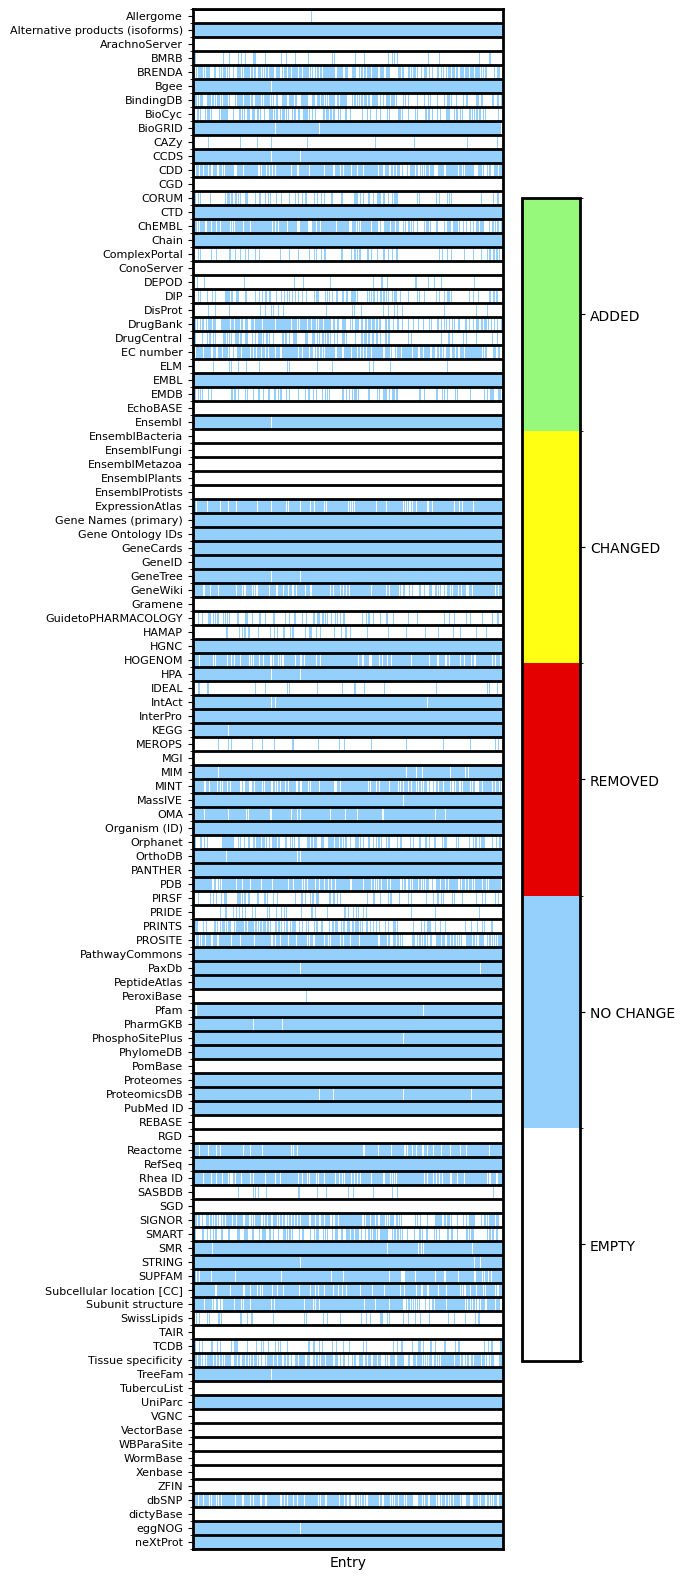

In [13]:
# Save query results to external database
df_database = df_query_results.reset_index(drop=True).drop_duplicates()
if compare:
    compare_on_index = ["Entry"]
    try:
        df_previous = pd.read_csv(
            database_dirpath / f"{db_tag}_{GEM_NAME}.tsv",
            sep="\t",
            index_col=None,
            dtype=str,
        )
        df_previous = df_previous.replace(float("nan"), pd.NA)
    except FileNotFoundError:
        df_previous = pd.DataFrame([], columns=compare_on_index)
    df_comparision = compare_tables(
        df_previous.set_index(compare_on_index), df_database.set_index(compare_on_index)
    )

    fig, ax = plt.subplots(1, 1, figsize=compare_figsize)
    ax.yaxis.set_tick_params(labelsize=8)
    ax = visualize_comparison(df_comparision)


if overwrite:
    df_database.to_csv(
        database_dirpath / f"{db_tag}_{GEM_NAME}.tsv", sep="\t", index=False
    )

df_database

## Format UniProt information for annotation files
### Genes
#### Map to chosen MIRIAMs
As formatting may be needed for some MIRIAMS, keep it simple for now until formatting methods are developed. 

In [14]:
annotation_type = "genes"

# Keeping it simple for now, group items regardless of isoforms for the time being
uniprot_miriam_mapping = get_label_miriam_mapping_UniProt(
    get_query_fields_UniProt(miriam_only=True)
)
uniprot_miriam_mapping["Proteomes"] = "chromosome"

merge_key = {
    v: k for k, v in uniprot_miriam_mapping.items() if v in df_model_mappings.columns
}[mapping_key]
df_annotations = df_model_mappings.set_index(mapping_key).merge(
    df_database, left_index=True, right_on=merge_key, how="left"
)
df_annotations = (
    df_annotations.set_index(annotation_type)
    .loc[:, list(uniprot_miriam_mapping)]
    .rename(uniprot_miriam_mapping, axis=1)
)
uniprot_columns = ["uniprot", "uniprot.isoform", "uniprot.chain"]
# For the most part, these columns do not require any reformatting or are easy to work with.
annotation_columns = [
    "hgnc.symbol",
    "ec-code",
    "taxonomy",
    "uniparc",
    # Reactions
    "rhea",
    # Gene Ontology (GO)
    "go",
    # Sequence
    "ccds",
    "ena.embl",
    "refseq",
    # 3D Structure
    "bmrb",
    "pdb",
    "sasbdb",
    "smr",
    # Protein-protein interaction
    "biogrid",
    "complexportal",
    "dip",
    "intact",
    # Chemistry databases
    "chembl.target",
    "drugbank",
    "iuphar.receptor",
    # Protein family/group databases
    "cazy",
    "ideal",
    "merops",
    "peroxibase",
    "tcdb",
    # Genetic variation/Polymorphism and mutation databases
    "dbsnp",
    # Proteomic databases
    "proteomicsdb.protein",
    # Genome annotation databases
    "ensembl",
    "ncbigene",
    ## Organism-specific
    "kegg.genes",
    "genecards",
    "hgnc",
    "hpa",
    "mim",
    "nextprot",
    "orphanet",
    "pharmgkb.gene",
    # Phylogenomic databases
    "eggnog",
    "genetree",
    "hogenom",
    "oma.grp",
    "orthodb",
    "treefam",
    # Enzyme and pathway databases
    "biocyc",
    "brenda",
    "reactome",
    # Miscellaneous databases
    "genewiki",
    # Gene expression databases
    "bgee.gene",
    ## Family and domain databases
    "cdd",
    "disprot",
    "hamap",
    "interpro",
    "panther.family",
    "pfam",
    "pirsf",
    "prints",
    "prosite",
    "smart",
    "supfam",
    "chromosome",
]
df_annotations["chromosome"] = df_annotations["chromosome"].apply(
    lambda x: x.split(" ")[-1]
)
df_annotations = df_annotations.loc[:, uniprot_columns + annotation_columns]
print(f"Fields searched: {df_annotations.shape[1]}")
all_na = df_annotations.T[df_annotations.isna().all(axis=0)].index
annotation_columns = [x for x in annotation_columns if x not in all_na]
df_annotations = df_annotations.dropna(how="all", axis=1)
print(f"Empty dropped: {len(all_na)}")
print(f"Remaining: {df_annotations.shape[1]}")
df_annotations = df_annotations.reset_index(drop=False).replace(pd.NA, "")
df_annotations

Fields searched: 63
Empty dropped: 0
Remaining: 63


,genes,uniprot,uniprot.isoform,uniprot.chain,hgnc.symbol,ec-code,taxonomy,uniparc,rhea,go,...,hamap,interpro,panther.family,pfam,pirsf,prints,prosite,smart,supfam,chromosome
0,A4GALT,Q9NPC4,ALTERNATIVE PRODUCTS:,"CHAIN 1..353; /note=""Lactosylceramide 4-alpha-...",A4GALT,2.4.1.228,9606,UPI000003FF92,RHEA:11924 RHEA:60044,GO:0000139; GO:0001576; GO:0006688; GO:0007009...,...,,IPR007652;IPR051981;IPR007577;IPR029044;,PTHR12042:SF17;PTHR12042;,PF04572;PF04488;,,,,,SSF53448;,22
1,AARS1,P49588,ALTERNATIVE PRODUCTS: Event=Alternative splic...,"CHAIN 1..968; /note=""Alanine--tRNA ligase, cyt...",AARS1,6.-.-.-; 6.1.1.7,9606,UPI0000169F0B,RHEA:12540 RHEA:80271 RHEA:80275,GO:0000049; GO:0002161; GO:0002196; GO:0004813...,...,MF_00036_B;,IPR045864;IPR002318;IPR018162;IPR018165;IPR018...,PTHR11777:SF36;PTHR11777;,PF02272;PF01411;PF07973;,,PR00980;,PS50860;,SM00863;,SSF55681;SSF101353;SSF55186;SSF50447;,16
2,AASDHPPT,Q9NRN7,ALTERNATIVE PRODUCTS: Event=Alternative splic...,"CHAIN 1..309; /note=""L-aminoadipate-semialdehy...",AASDHPPT,2.7.8.7,9606,UPI0000034CAD,RHEA:12068 RHEA:46564,GO:0000287; GO:0005829; GO:0008897; GO:0009258...,...,,IPR008278;IPR037143;IPR055066;IPR050559;,PTHR12215:SF10;PTHR12215;,PF22624;PF01648;,,,,,SSF56214;,11
3,ABCA1,O95477,ALTERNATIVE PRODUCTS:,"CHAIN 1..2261; /note=""Phospholipid-transportin...",ABCA1,7.6.2.1,9606,UPI000013E441,RHEA:38583 RHEA:38567 RHEA:38903 RHEA:39051,GO:0002790; GO:0005102; GO:0005524; GO:0005548...,...,,IPR003593;IPR013525;IPR003439;IPR017871;IPR026...,PTHR19229:SF250;PTHR19229;,PF12698;PF00005;PF23321;,,,PS00211;PS50893;,SM00382;,SSF52540;,9
4,ABCA7,Q8IZY2,ALTERNATIVE PRODUCTS: Event=Alternative splic...,"CHAIN 1..2146; /note=""Phospholipid-transportin...",ABCA7,7.6.2.1,9606,UPI000013D3A4,RHEA:38583 RHEA:38567,GO:0000139; GO:0001891; GO:0005524; GO:0005548...,...,,IPR003593;IPR013525;IPR003439;IPR017871;IPR026...,PTHR19229:SF250;PTHR19229;,PF12698;PF00005;PF23321;,,,PS00211;PS50893;,SM00382;,SSF52540;,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
815,YES1,P07947,ALTERNATIVE PRODUCTS:,"CHAIN 2..543; /note=""Tyrosine-protein kinase Y...",YES1,2.7.10.2,9606,UPI0000062316,RHEA:10596,GO:0001784; GO:0002862; GO:0004713; GO:0004715...,...,,IPR011009;IPR050198;IPR000719;IPR017441;IPR001...,PTHR24418;,PF07714;PF00017;PF00018;,,PR00401;PR00452;PR00109;,PS00107;PS50011;PS00109;PS50001;PS50002;,SM00252;SM00326;SM00219;,SSF56112;SSF55550;SSF50044;,18
816,ZDHHC2,Q9UIJ5,ALTERNATIVE PRODUCTS:,"CHAIN 1..367; /note=""Palmitoyltransferase ZDHH...",ZDHHC2,2.3.1.-; 2.3.1.225,9606,UPI000004A02F,RHEA:36683 RHEA:59736 RHEA:59740,GO:0000139; GO:0005783; GO:0005789; GO:0005794...,...,,IPR001594;IPR039859;,PTHR12246;,PF01529;,,,PS50216;,,,8
817,ZDHHC20,Q5W0Z9,ALTERNATIVE PRODUCTS: Event=Alternative splic...,"CHAIN 1..365; /note=""Palmitoyltransferase ZDHH...",ZDHHC20,2.3.1.-; 2.3.1.225,9606,UPI000045881B,RHEA:36683 RHEA:59736 RHEA:59740,GO:0000139; GO:0005783; GO:0005789; GO:0005794...,...,,IPR001594;IPR039859;,PTHR12246;,PF01529;,,,PS50216;,,,13
818,ZDHHC3,Q9NYG2,ALTERNATIVE PRODUCTS: Event=Alternative splic...,"CHAIN 1..299; /note=""Palmitoyltransferase ZDHH...",ZDHHC3,2.3.1.-; 2.3.1.225,9606,UPI000002B749,RHEA:36683 RHEA:59736 RHEA:59740,GO:0000139; GO:0005783; GO:0005794; GO:0006612...,...,,IPR001594;IPR039859;,PTHR12246;,PF01529;,,,PS50216;,,,3


In [15]:
df_isoforms = parse_isoforms_UniProt(
    df_annotations.loc[:, ["uniprot", "uniprot.isoform"]].copy(), add_canonical=True
)

df_canonical = df_isoforms[df_isoforms["uniprot.canonical"].apply(bool)].set_index(
    "uniprot"
)
df_canonical = df_canonical.apply(
    lambda x: x["uniprot.isoform"] if x["uniprot.isoform"] else x.name, axis=1
)
df_isoforms = df_isoforms.groupby("uniprot")[["uniprot.isoform"]].agg(
    lambda x: build_string(x)
)

df_chains = parse_chains_UniProt(
    df_annotations.loc[:, ["uniprot", "uniprot.chain"]].copy()
)
df_isoforms_chains = df_chains.merge(df_isoforms, right_index=True, left_on="uniprot")
df_isoforms_chains

,uniprot,uniprot.chain,uniprot.isoform
0,Q9NPC4,PRO_0000080578,
1,P49588,PRO_0000075281,P49588-1;P49588-2
2,Q9NRN7,PRO_0000175736,Q9NRN7-1;Q9NRN7-2
3,O95477,PRO_0000093288,
4,Q8IZY2,PRO_0000250674,Q8IZY2-1;Q8IZY2-2
...,...,...,...
815,P07947,PRO_0000088181,
816,Q9UIJ5,PRO_0000212859,
817,Q5W0Z9,PRO_0000212906,Q5W0Z9-1;Q5W0Z9-2;Q5W0Z9-3;Q5W0Z9-4
818,Q9NYG2,PRO_0000422064,Q9NYG2-1;Q9NYG2-2


genes: 820
uniprot: 820
uniprot.isoform: 1569
uniprot.chain: 871
hgnc.symbol: 821
ec-code: 538
taxonomy: 1
uniparc: 820
rhea: 1530
go: 5849
ccds: 1421
ena.embl: 8407
refseq: 3668
bmrb: 88
pdb: 12718
sasbdb: 46
smr: 808
biogrid: 821
complexportal: 405
dip: 248
intact: 813
chembl.target: 530
drugbank: 2439
iuphar.receptor: 188
cazy: 21
ideal: 43
merops: 41
peroxibase: 13
tcdb: 151
dbsnp: 5070
proteomicsdb.protein: 1752
ensembl: 2455
ncbigene: 822
kegg.genes: 824
genecards: 821
hgnc: 821
hpa: 819
mim: 1367
nextprot: 820
orphanet: 537
pharmgkb.gene: 814
eggnog: 614
genetree: 744
hogenom: 591
oma.grp: 785
orthodb: 590
treefam: 616
biocyc: 298
brenda: 413
reactome: 1081
genewiki: 621
bgee.gene: 819
cdd: 661
disprot: 47
hamap: 92
interpro: 2119
panther.family: 1235
pfam: 784
pirsf: 152
prints: 198
prosite: 412
smart: 184
supfam: 322
chromosome: 25


,genes,uniprot,uniprot.isoform,uniprot.chain,hgnc.symbol,ec-code,taxonomy,uniparc,rhea,go,...,hamap,interpro,panther.family,pfam,pirsf,prints,prosite,smart,supfam,chromosome
0,A4GALT,Q9NPC4,<NA>,PRO_0000080578,A4GALT,2.4.1.228,9606,UPI000003FF92,11924;60044,0000139;0001576;0006688;0007009;0008378;001564...,...,<NA>,IPR007652;IPR051981;IPR007577;IPR029044,PTHR12042:SF17;PTHR12042,PF04572;PF04488,<NA>,<NA>,<NA>,<NA>,SSF53448,22
1,AARS1,P49588,P49588-1;P49588-2,PRO_0000075281,AARS1,6.-.-.-;6.1.1.7,9606,UPI0000169F0B,12540;80271;80275,0000049;0002161;0002196;0004813;0005524;000563...,...,MF_00036_B,IPR045864;IPR002318;IPR018162;IPR018165;IPR018...,PTHR11777:SF36;PTHR11777,PF02272;PF01411;PF07973,<NA>,PR00980,PS50860,SM00863,SSF55681;SSF101353;SSF55186;SSF50447,16
2,AASDHPPT,Q9NRN7,Q9NRN7-1;Q9NRN7-2,PRO_0000175736,AASDHPPT,2.7.8.7,9606,UPI0000034CAD,12068;46564,0000287;0005829;0008897;0009258;0015939;001987...,...,<NA>,IPR008278;IPR037143;IPR055066;IPR050559,PTHR12215:SF10;PTHR12215,PF22624;PF01648,<NA>,<NA>,<NA>,<NA>,SSF56214,11
3,ABCA1,O95477,<NA>,PRO_0000093288,ABCA1,7.6.2.1,9606,UPI000013E441,38583;38567;38903;39051,0002790;0005102;0005524;0005548;0005768;000578...,...,<NA>,IPR003593;IPR013525;IPR003439;IPR017871;IPR026...,PTHR19229:SF250;PTHR19229,PF12698;PF00005;PF23321,<NA>,<NA>,PS00211;PS50893,SM00382,SSF52540,9
4,ABCA7,Q8IZY2,Q8IZY2-1;Q8IZY2-2,PRO_0000250674,ABCA7,7.6.2.1,9606,UPI000013D3A4,38583;38567,0000139;0001891;0005524;0005548;0005783;000579...,...,<NA>,IPR003593;IPR013525;IPR003439;IPR017871;IPR026...,PTHR19229:SF250;PTHR19229,PF12698;PF00005;PF23321,<NA>,<NA>,PS00211;PS50893,SM00382,SSF52540,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
815,YES1,P07947,<NA>,PRO_0000088181,YES1,2.7.10.2,9606,UPI0000062316,10596,0001784;0002862;0004713;0004715;0005102;000552...,...,<NA>,IPR011009;IPR050198;IPR000719;IPR017441;IPR001...,PTHR24418,PF07714;PF00017;PF00018,<NA>,PR00401;PR00452;PR00109,PS00107;PS50011;PS00109;PS50001;PS50002,SM00252;SM00326;SM00219,SSF56112;SSF55550;SSF50044,18
816,ZDHHC2,Q9UIJ5,<NA>,PRO_0000212859,ZDHHC2,2.3.1.-;2.3.1.225,9606,UPI000004A02F,36683;59736;59740,0000139;0005783;0005789;0005794;0005886;000661...,...,<NA>,IPR001594;IPR039859,PTHR12246,PF01529,<NA>,<NA>,PS50216,<NA>,<NA>,8
817,ZDHHC20,Q5W0Z9,Q5W0Z9-1;Q5W0Z9-2;Q5W0Z9-3;Q5W0Z9-4,PRO_0000212906,ZDHHC20,2.3.1.-;2.3.1.225,9606,UPI000045881B,36683;59736;59740,0000139;0005783;0005789;0005794;0005886;000661...,...,<NA>,IPR001594;IPR039859,PTHR12246,PF01529,<NA>,<NA>,PS50216,<NA>,<NA>,13
818,ZDHHC3,Q9NYG2,Q9NYG2-1;Q9NYG2-2,PRO_0000422064,ZDHHC3,2.3.1.-;2.3.1.225,9606,UPI000002B749,36683;59736;59740,0000139;0005783;0005794;0006612;0008277;001602...,...,<NA>,IPR001594;IPR039859,PTHR12246,PF01529,<NA>,<NA>,PS50216,<NA>,<NA>,3


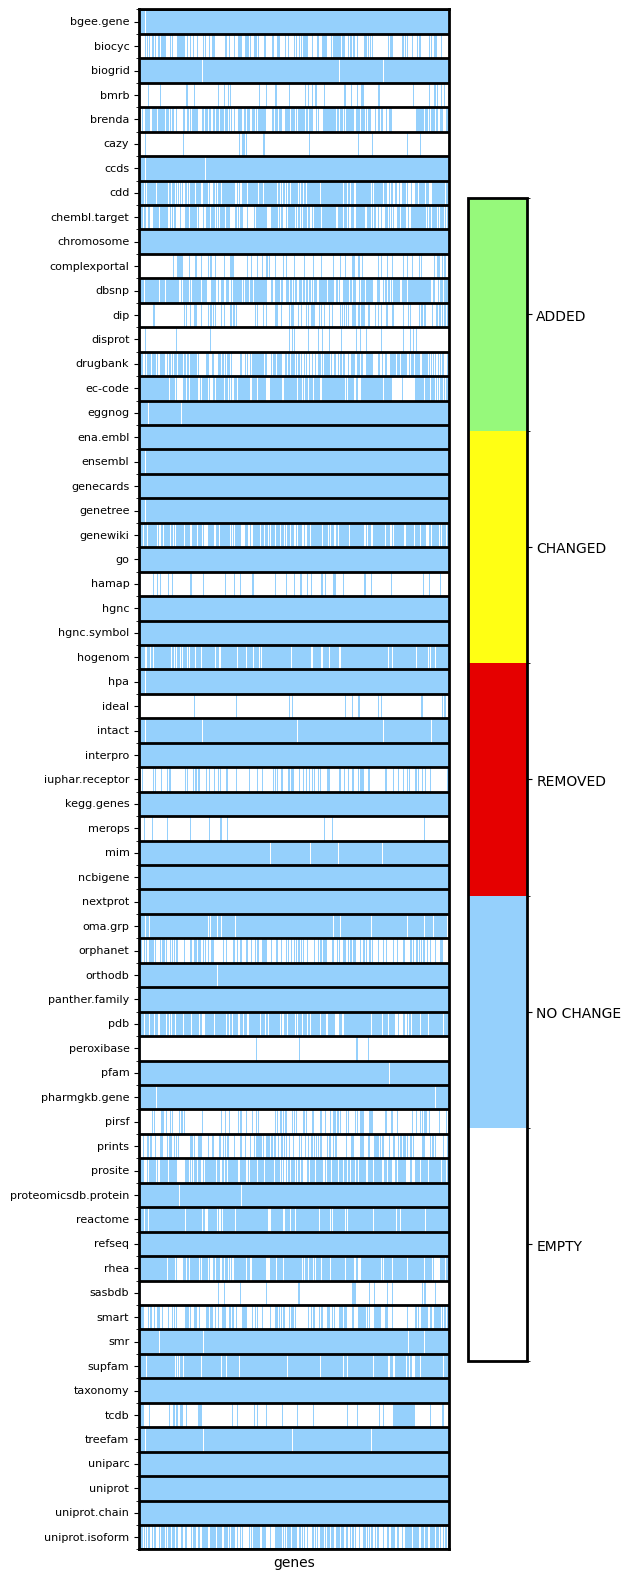

In [16]:
for col, series in df_isoforms_chains.items():
    df_annotations[col] = series

for idx, row in df_annotations.loc[:, annotation_columns].iterrows():
    uniprot_id, isoform_id = df_isoforms_chains.loc[idx, ["uniprot", "uniprot.isoform"]]
    if isoform_id and len(isoform_id.split(";")) != 1:
        isoform_id = None
    # No isoform ID set, just aggregate all without regards to isoform.
    row = row.apply(
        lambda x: (
            get_isoform_value_from_entry_UniProt(x, isoform_id)
            if get_isoform_value_from_entry_UniProt(x, isoform_id).strip()
            else x
        )
    )
    row = row.apply(lambda x: x.strip().rstrip(";"))
    # A duplicate reindexing error may here may mean duplicate columns in annotation column values
    df_annotations.loc[idx, annotation_columns] = row.values
# Clean up other annotations
keys = ["rhea", "go", "hgnc"]
for key in keys:
    if key in df_annotations.columns:
        df_annotations[key] = (
            df_annotations[key]
            .fillna("")
            .apply(
                lambda x: build_string(
                    [s.lstrip(f"{key.upper()}:") for s in split_string(x)]
                )
            )
        )


df_annotations = df_annotations.replace(float("nan"), pd.NA).replace("", pd.NA)
if compare:
    compare_on_index = [annotation_type]
    try:
        df_previous = pd.read_csv(
            annotation_dirpath / f"{annotation_type}_{db_tag}.tsv",
            sep="\t",
            index_col=None,
            dtype=str,
        )
        df_previous = df_previous.replace(float("nan"), pd.NA).replace("", pd.NA)
    except FileNotFoundError:
        df_previous = pd.DataFrame([], columns=compare_on_index)
    df_comparision = compare_tables(
        df_previous.set_index(compare_on_index),
        df_annotations.set_index(compare_on_index),
    )

    fig, ax = plt.subplots(1, 1, figsize=compare_figsize)
    ax.yaxis.set_tick_params(labelsize=8)
    ax = visualize_comparison(df_comparision)

if display_nunique:
    for col in df_annotations.columns:
        df = (
            df_annotations[col]
            .apply(lambda x: split_string(x))
            .explode(col)
            .drop_duplicates()
        )
        print(f"{df.name}: {df.nunique()}")
if overwrite:
    df_annotations.to_csv(
        annotation_dirpath / f"{annotation_type}_{db_tag}.tsv", sep="\t", index=False
    )

df_annotations

## Format Complex Table
### Complexes and stoichiometry
Information extracted here can be useful for protein constrained modeling

uniprot         820
hgnc.symbol     820
taxonomy          1
subunit_text    650
dtype: int64


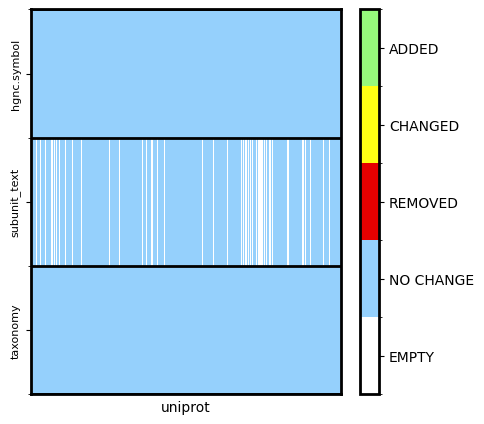

In [17]:
rename_mapping = {
    "Entry": "uniprot",
    "Gene Names (primary)": "hgnc.symbol",
    "Organism (ID)": "taxonomy",
    "Subunit structure": "subunit_text",
}
df_complex_results = (
    df_query_results.loc[:, list(rename_mapping)].rename(rename_mapping, axis=1).copy()
)

if compare:
    compare_on_index = ["uniprot"]
    try:
        df_previous = pd.read_csv(
            database_dirpath / "uniprot_complexes.tsv",
            sep="\t",
            index_col=None,
            dtype=str,
        )
        df_previous = df_previous.replace(float("nan"), pd.NA).replace("", pd.NA)
    except FileNotFoundError:
        df_previous = pd.DataFrame([], columns=compare_on_index)
    df_comparision = compare_tables(
        df_previous.set_index(compare_on_index),
        df_complex_results.set_index(compare_on_index),
    )

    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.yaxis.set_tick_params(labelsize=8)
    ax = visualize_comparison(df_comparision)

if display_nunique:
    print(f"{df_complex_results.nunique()}")

if overwrite:
    df_complex_results.to_csv(
        database_dirpath / "uniprot_complexes.tsv",
        sep="\t",
        index=False,
    )

#### Parse complexes keywords

In [18]:
# TODO finish automation component
# subunit_terms_mapping_dict = {
#     # Contains terms for subunit mapping.
#     # Additional parsing needed for terms associated with more than one key and/or heteromultimeric complexes
#     # May occur for complexes that have overlapping terms (e.g., decamer and undecamer)
#     # A value of `0` indicates specific parsing or manual mappping is needed and can be determined from just the term.
# #     0: {"polypeptide", "oligomer", "complex", "catalytic subunit", "multisubunit", "regulatory subunit", "auxillary subunit", "alpha subunit", "beta subunit", "gamma subunit", "delta subunit", "proteasome", "multimer", "polymers"},
# #     1: {"1 subunit", "monomer"},
# #     2: {"2 subunits", "dimer"},
# #     3: {"3 subunits", "trimer"},
# #     4: {"4 subunits", "tetramer"},
# #     5: {"5 subunits", "pentamer"},
# #     6: {"6 subunits", "hexamer"},
# #     7: {"7 subunits", "heptamer"},
# #     8: {"8 subunits", "octamer"},
# #     9: {"9 subunits", "nonomer"},
# #     10: {"10 subunits", "decamer"},
# #     11: {"11 subunits", "undecamer"},
# #     12: {"12 subunits", "dodecamer"},
# #     13: {"13 subunits", "tridecamer"},
# #     14: {"14 subunits", "tetradecamer"},
# #     15: {"15 subunits", "pentadecamer"},
# #     16: {"16 subunits", "hexadecamer"},
# #     17: {"17 subunits", "heptadecamer"},
# #     18: {"18 subunits", "octaadecamer"},
# #     19: {"19 subunits", "nonadecamer"},
# #     20: {"20 subunits", "didecamer"},
# #     22: {"22 subunits"},
# #     24: {"24 subunits"},
# #     26: {"26 subunits"},
# # }

# data = {}
# for uniprot_id, subunit_text in df_complex_results["subunit_text"].dropna().items():
#     data[uniprot_id] = {
#         "subunit_text": subunit_text
#     }
#     # First determine if any subunit matches can be made.
#     matches = set()
#     for n_subunits, search_terms in subunit_terms_mapping_dict.items():
#         matches.update([match.lower() for term in search_terms for match in re.findall(term, subunit_text, re.IGNORECASE)])
#     if not matches:
#         data[uniprot_id].update({
#             "matches": pd.NA,
#             "manual": True,
#         })
#         continue
#     elif matches:

#     break


# # df_model_complexes = pd.DataFrame.from_dict(data, orient="index")


# # # if overwrite:
# # #     df_isoforms_final.to_csv(database_dirpath / "uniprot_isoforms.tsv", sep="\t", index=False)
# # #     df_erythroid.to_csv(database_dirpath / "uniprot_isoforms_erythroid.tsv", sep="\t", index=False)
# # # else:
# # #     df_isoforms_final.to_csv(ROOT_PATH / INTERIM_PATH / "uniprot_isoforms.tsv", sep="\t", index=False)
# # #     df_erythroid.to_csv(ROOT_PATH / INTERIM_PATH / "uniprot_isoforms_erythroid.tsv", sep="\t", index=False)
# # # df_erythroid
# # df_model_complexes = df_model_mappings.merge(df_model_complexes, left_on="uniprot", right_index=True, how="inner")
# # df_model_complexes

## Load Isoforms and Sequences
### Isoforms
#### Parse data into initial table of isoforms

In [19]:
erythro_keywords = [
    "erythro",
    "erythrocyte",
    "erythroid",
    "red blood cell",
    "rbc",
    "R-type",
    "P5N-I",
    "reticulocyte",
]
backup_keywords = ["cyto", "retic", "cell membrane"]
avoid_keywords = ["non-erythro", "mito", "not detected", "synaptic", "testis"]

rename_mapping = {
    "Entry": "uniprot",
    "Gene Names (primary)": "hgnc.symbol",
    "Organism (ID)": "taxonomy",
    "Alternative products (isoforms)": "uniprot.isoform",
    "Tissue specificity": "tissue_specificity",
    "Subcellular location [CC]": "subcellular_location",
}
columns_to_search = ["tissue_specificity", "subcellular_location"]

df_tissue_specificity = (
    df_query_results.loc[:, list(rename_mapping)].rename(rename_mapping, axis=1).copy()
)
df_isoforms = parse_isoforms_UniProt(
    df_tissue_specificity.loc[:, ["uniprot", "uniprot.isoform"]].copy(),
    add_canonical=True,
)
df_isoforms = df_isoforms.merge(
    df_tissue_specificity[columns_to_search],
    left_on="uniprot",
    right_index=True,
    how="left",
)

df_isoforms["erythroid"] = pd.NA
df_isoforms["backup"] = pd.NA
df_isoforms["avoid"] = pd.NA
df_isoforms["keywords.erythroid"] = pd.NA
df_isoforms["keywords.backup"] = pd.NA
df_isoforms["keywords.avoid"] = pd.NA
all_names = sorted(
    df_isoforms["uniprot.isoform.name"].replace("", pd.NA).dropna().unique()
)
all_synonyms = sorted(
    df_isoforms["uniprot.isoform.synonyms"].replace("", pd.NA).dropna().unique()
)
for col_to_search in columns_to_search:
    for idx, value_string in df_isoforms[col_to_search].dropna().items():
        if not re.search(r"\[Isoform (.+?(?=\]))", value_string):
            continue
        for isoform_entry in value_string.split(";"):
            match = re.search(r"\[Isoform (.+?(?=\]))", isoform_entry)
            if not match:
                continue

            isoform_name_or_synonym = match.group(1)
            if not (
                df_isoforms.loc[idx, "uniprot.isoform.name"] == isoform_name_or_synonym
                or df_isoforms.loc[idx, "uniprot.isoform.synonyms"]
                == isoform_name_or_synonym
            ):
                continue

            for col, keywords in zip(
                ["erythroid", "backup", "avoid"],
                [erythro_keywords, backup_keywords, avoid_keywords],
            ):
                found_keywords = set()
                for k in keywords:
                    found_keywords.update(
                        re.findall(k, isoform_entry.strip(), re.IGNORECASE)
                    )
                if df_isoforms.fillna("").loc[idx, f"keywords.{col}"]:
                    found_keywords.update(
                        split_string(df_isoforms.loc[idx, f"keywords.{col}"])
                    )
                df_isoforms.loc[idx, f"keywords.{col}"] = build_string(found_keywords)

for col, keywords in zip(
    ["erythroid", "backup", "avoid"],
    [erythro_keywords, backup_keywords, avoid_keywords],
):
    df_isoforms[f"keywords.{col}"] = df_isoforms[f"keywords.{col}"].apply(
        lambda x: set(split_string(x)) if isinstance(x, str) else set()
    )
    for k in keywords:
        df_isoforms[f"keywords.{col}"] = (
            df_isoforms[[f"keywords.{col}", "uniprot.isoform.name"]]
            .fillna("")
            .apply(
                lambda x: x[f"keywords.{col}"].union(
                    set(re.findall(k, x["uniprot.isoform.name"], re.IGNORECASE))
                ),
                axis=1,
            )
        )
        df_isoforms[f"keywords.{col}"] = (
            df_isoforms[[f"keywords.{col}", "uniprot.isoform.synonyms"]]
            .fillna("")
            .apply(
                lambda x: x[f"keywords.{col}"].union(
                    set(re.findall(k, x["uniprot.isoform.synonyms"], re.IGNORECASE))
                ),
                axis=1,
            )
        )
    df_isoforms[f"keywords.{col}"] = df_isoforms[f"keywords.{col}"].apply(
        lambda x: build_string([s for s in x if s])
    )
df_isoforms = df_isoforms.replace(float("nan"), pd.NA).replace("", pd.NA)
df_isoforms["erythroid"] = df_isoforms["keywords.erythroid"].notna()
df_isoforms["backup"] = df_isoforms["keywords.backup"].notna()
df_isoforms["avoid"] = df_isoforms["keywords.avoid"].notna()
# Remove those found in both categories from "erythroid", usually caused by words like `non-erythro`
df_isoforms.loc[
    df_isoforms[df_isoforms[["erythroid", "avoid"]].all(axis=1)].index,
    "erythroid",
] = False
# Erythroid easily serves as a backup option
df_isoforms.loc[
    df_isoforms[df_isoforms[["erythroid"]].all(axis=1)].index,
    "backup",
] = True

df_isoforms["canonical"] = df_isoforms["uniprot.canonical"]
df_isoforms["sequence.id"] = df_isoforms.fillna("").apply(
    lambda x: x["uniprot.isoform"] if x["uniprot.isoform"] else x["uniprot"], axis=1
)
df_isoforms = df_isoforms.replace(float("nan"), pd.NA).replace("", pd.NA)
df_isoforms = (
    df_isoforms.loc[
        :,
        [
            "uniprot",
            "uniprot.isoform",
            "sequence.id",
            "canonical",
            "erythroid",
            "backup",
            "avoid",
            "keywords.erythroid",
            "keywords.backup",
            "keywords.avoid",
        ],
    ]
    .drop_duplicates()
    .reset_index(drop=True)
)

### Sequences
#### Extract sequences using UniParc Mapping

In [20]:
df_isoforms_sequences = df_isoforms[
    df_isoforms.apply(lambda x: x["sequence.id"].startswith(x["uniprot"]), axis=1)
].copy()
query_ids = df_isoforms_sequences["sequence.id"].unique()

query_parameters = {
    "format": "tsv",
    "size": 500,
    "compressed": True,
    "fields": ",".join(
        [
            "sequence",
            "length",
        ]
    ),
}

query_key = "initial"
df_results, uniparc, failed_ids, obselete_counts = query_UniProt(
    list(query_ids),
    query_parameters=query_parameters,
    from_db="UniProtKB_AC-ID",
    to_db="UniParc",
    return_failed=True,
)

if failed_ids:
    print(failed_ids)

df_isoforms_sequences = df_isoforms_sequences.merge(
    df_results.set_index("From").rename(
        {
            "Sequence": "sequence",
            "Length": "sequence.length",
            "mass": "sequence.mass",
        },
        axis=1,
    ),
    left_on="sequence.id",
    right_index=True,
)

# #  The following code can be used to address entries with issues in extractions. LDHB example.
# df_isoforms_sequences = pd.concat(
#     (
#         df_isoforms_sequences,
#         pd.DataFrame.from_dict(
#             {
#                 "uniprot": "P07195",
#                 "sequence.id": "P07195",
#                 "canonical": True,
#                 "erythroid": False,
#                 "backup": False,
#                 "avoid": False,
#                 "sequence": "MATLKEKLIAPVAEEEATVPNNKITVVGVGQVGMACAISILGKSLADELALVDVLEDKLKGEMMDLQHGSLFLQTPKIVADKDYSVTANSKIVVVTAGVRQQEGESRLNLVQRNVNVFKFIIPQIVKYSPDCIIIVVSNPVDILTYVTWKLSGLPKHRVIGSGCNLDSARFRYLMAEKLGIHPSSCHGWILGEHGDSSVAVWSGVNVAGVSLQELNPEMGTDNDSENWKEVHKMVVESAYEVIKLKGYTNWAIGLSVADLIESMLKNLSRIHPVSTMVKGMYGIENEVFLSLPCILNARGLTSVINQKLKDDEVAQLKKSADTLWDIQKDLKDL",
#                 "sequence.length": "334",
#             },
#             orient="index",
#         ).T,
#     ),
#     axis=0,
# ).convert_dtypes()

df_isoforms_sequences = df_isoforms_sequences.reset_index(drop=True)

if overwrite:
    df_isoforms_sequences.to_csv(
        database_dirpath / f"{UNIPROT_DB_TAG}_isoforms_sequences.tsv",
        sep="\t",
        index=False,
    )

df_isoforms_sequences

Fetched: 500 / 1856
Fetched: 1000 / 1856
Fetched: 1500 / 1856


Number of failed query IDs : 1


Fetched: 1856 / 1856


Number of failed IDs : 1


{'P0C869-4'}


,uniprot,uniprot.isoform,sequence.id,canonical,erythroid,backup,avoid,keywords.erythroid,keywords.backup,keywords.avoid,sequence,sequence.length
0,A0AVT1,A0AVT1-1,A0AVT1-1,True,False,False,False,<NA>,<NA>,<NA>,MEGSEPVAAHQGEEASCSSWGTGSTNKNLPIMSTASVEIDDALYSR...,1052
1,A0AVT1,A0AVT1-2,A0AVT1-2,False,False,False,False,<NA>,<NA>,<NA>,MLKNFALLGVGTSKEKGMITVTDPDLIEKSNLNRQFLFRPHHIQKP...,578
2,A0AVT1,A0AVT1-3,A0AVT1-3,False,False,False,False,<NA>,<NA>,<NA>,MEGSEPVAAHQGEEASCSSWGTGSTNKNLPIMSTASVEIDDALYSR...,389
3,A0AVT1,A0AVT1-4,A0AVT1-4,False,False,False,False,<NA>,<NA>,<NA>,MEGSEPVAAHQGEEASCSSWGTGSTNKNLPIMSTASVEIDDALYSR...,340
4,A4D126,A4D126-1,A4D126-1,True,False,False,False,<NA>,<NA>,<NA>,MEAGPPGSARPAEPGPCLSGQRGADHTASASLQSVAGTEPGRHPQA...,451
...,...,...,...,...,...,...,...,...,...,...,...,...
1851,Q9Y6M4,Q9Y6M4-3,Q9Y6M4-3,False,False,False,False,<NA>,<NA>,<NA>,MENKKKDKDKSDDRMARPSGRSGHNTRGTGSSSSGVLMVGPNFRVG...,423
1852,Q9Y6M4,Q9Y6M4-4,Q9Y6M4-4,False,False,False,False,<NA>,<NA>,<NA>,MENKKKDKDKSDDRMARPSGRSGHNTRGTGSSSSGVLMVGPNFRVG...,424
1853,Q9Y6M4,Q9Y6M4-5,Q9Y6M4-5,False,False,False,False,<NA>,<NA>,<NA>,MKSRAPQLHLEYRFYKQLGSGDGIPQVYYFGPCGKYNAMVLELLGP...,348
1854,Q9Y6M4,Q9Y6M4-6,Q9Y6M4-6,False,False,False,False,<NA>,<NA>,<NA>,MVLELLGPSLEDLFDLCDRTFSLKTVLMIAIQLISRMEYVHSKNLI...,311


In [21]:
df_model_mappings.merge(df_isoforms_sequences[df_isoforms_sequences["erythroid"]])

,genes,uniprot,uniprot.isoform,sequence.id,canonical,erythroid,backup,avoid,keywords.erythroid,keywords.backup,keywords.avoid,sequence,sequence.length
0,ACHE,P22303,P22303-2,P22303-2,False,True,True,False,erythro,Cell membrane,<NA>,MRPPQCLLHTPSLASPLLLLLLWLLGGGVGAEGREDAELLVTVRGG...,617
1,ARG1,P05089,P05089-2,P05089-2,False,True,True,False,Erythroid;Erythro,<NA>,<NA>,MSAKSRTIGIIGAPFSKGQPRGGVEEGPTVLRKAGLLEKLKEQVTQ...,330
2,CYB5A,P00167,P00167-2,P00167-2,False,True,True,False,Erythro;Erythrocyte,Cyto,<NA>,MAEQSDEAVKYYTLEEIQKHNHSKSTWLILHHKVYDLTKFLEEHPG...,98
3,CYB5R3,P00387,P00387-2,P00387-2,False,True,True,False,erythro;erythroid,Cyto,<NA>,MKLFQRSTPAITLESPDIKYPLRLIDREIISHDTRRFRFALPSPQH...,278
4,GCNT2,Q8N0V5,Q8N0V5-3,Q8N0V5-3,False,True,True,False,reticulocyte,retic,<NA>,MNFWRYCFFAFTLLSVVIFVRFYSSQLSPPKSYEKLNSSSERYFRK...,402
5,HK1,P19367,P19367-2,P19367-2,False,True,True,False,Erythro;Erythrocyte,<NA>,<NA>,MDCEHSLSLPCRGAEAWEIGIDKYLYAMRLSDETLIDIMTRFRKEM...,916
6,HMBS,P08397,P08397-2,P08397-2,False,True,True,False,erythro;Erythrocyte;Erythro;erythroid,<NA>,<NA>,MRVIRVGTRKSQLARIQTDSVVATLKASYPGLQFEIIAMSTTGDKI...,344
7,NT5C3A,Q9H0P0,Q9H0P0-1,Q9H0P0-1,False,True,True,False,P5N-I,<NA>,<NA>,MTNQESAVHVKMMPEFQKSSVRIKNPTRVEEIICGLIKGGAAKLQI...,297
8,PKLR,P30613,P30613-1,P30613-1,True,True,True,False,R-type,<NA>,<NA>,MSIQENISSLQLRSWVSKSQRDLAKSILIGAPGGPAGYLRRASVAQ...,574
9,SLC4A1,P02730,P02730-1,P02730-1,True,True,True,False,Erythro;Erythrocyte,<NA>,<NA>,MEELQDDYEDMMEENLEQEEYEDPDIPESQMEEPAAHDTEATATDY...,911
